In [1]:
import pyaudio
import numpy as np 
import librosa
import wave
#from sklearn.externals import joblib
from joblib import load, dump 
import RPi.GPIO as GPIO
import threading
import queue
import time
import json
from vosk import Model, KaldiRecognizer
import wave
import sys 
sys.path.append("/home/pi/mic_hat/interfaces")
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [2]:
try:
    import pixels as led_interface
except ImportError:
    print("NOTE: add 'interfaces' folder to path: export PYTHONPATH=../../mic_hat/interfaces (if in EGEC-548/code folder)")
# ReSpeaker Parameters
BUTTON = 11
RESPEAKER_RATE = 16000
RESPEAKER_CHANNELS = 1
RESPEAKER_WIDTH = 2
RESPEAKER_INPUT_INDEX = 1 # Refer to input device id (getDeviceInfo.py to get index)
CHUNK = 16000

# Vosk model
model = Model('vosk-model-small-en-us-0.15')
rec = KaldiRecognizer(model, RESPEAKER_RATE)

# Create a buffer to hold the delayed samples
buffer = np.zeros(CHUNK)
# LEDs on ReSpeaker HAT
leds = led_interface.Pixels()
leds.off()
# Make left LED green
# led_colors = [left LED r, left LED g, left LED b,
# center LED r, center LED g, center LED b,
# right LED r, right LED g, right LED b]
led_colors = [0] * 3 * 3 # Make all 0
led_colors[1] = 1 # left LED g = 1
# Button on ReSpeaker HAT
GPIO.setmode(GPIO.BOARD)
GPIO.setup(BUTTON, GPIO.IN)
btn_state = False



LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-en-us-0.15/graph/HCLr.fst vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo vosk-model-small-en-us-0.15/graph/phones/word_boundary.int


In [3]:
# Download the VADER lexicon if you haven't already
nltk.download('vader_lexicon')
# Initialize the VADER sentiment intensity analyzer
sid= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /home/pi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
def process_audio_chunk(raw_audio, sample_rate):
    audio_array = np.frombuffer(raw_audio, dtype=np.int16).astype(np.float32) / 32768.0
    return audio_array

def preprocess_audio(audio_data, sample_rate):
    #convert audio to mono
    mono_audio = librosa.to_mono(audio_data)
    #apply hi pass filter to remove low freq noise
    filtered_audio = librosa.effects.preemphasis(mono_audio)

    return filtered_audio
    

In [5]:
def extract_tempo(audio_data, sample_rate):
    #estimated tempo
    tempo, _ = librosa.beat.beat_track(y= audio_data, sr=sample_rate)
    return tempo 

def extract_pitch(audio_data, sample_rate):
    #estimated tempo
    #pitches, magnitudes 
    pitches = librosa.pyin(
        y= audio_data, 
        sr=sample_rate,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7')
    )
    avg_pitch = np.nanmean(pitches)
    return avg_pitch 

def extract_features(audio_data, sample_rate):
    #compute mel frquency cepstral coefficients
    mfcc = librosa.feature.mfcc(y= audio_data, sr=sample_rate, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)

    #compute chroma
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
    chroma_mean = chroma.mean(axis=1)

    #compute spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
    spectral_contrast_mean = spectral_contrast.mean(axis=1)

    #extract tempo
    tempo = extract_tempo(audio_data, sample_rate)

    pitch = extract_pitch(audio_data, sample_rate)

    features = np.hstack((mfcc_mean, chroma_mean, spectral_contrast_mean, tempo, pitch))
    
    return features 
'''
def end_song(silence_count, silence_threshold):
    #silence_count: count of consecutive silence chunks
    #silence_threshold: threshold for consecutie silence chunks that determine the song has ended
    if (silence_count >= silence_threshold):
        return True
    return False
'''

'\ndef end_song(silence_count, silence_threshold):\n    #silence_count: count of consecutive silence chunks\n    #silence_threshold: threshold for consecutie silence chunks that determine the song has ended\n    if (silence_count >= silence_threshold):\n        return True\n    return False\n'

In [6]:
def save_audio_file(audio_frames, file_output):
    with wave.open(file_output, 'wb') as wf: 
        wf.setnchannels(RESPEAKER_CHANNELS)
        wf.setsampwidth(2)
        wf.setframerate(RESPEAKER_RATE)
        wf.writeframes(b''.join(audio_frames))

def analyze_audio_file(filename):
    audio_data, sample_rate = librosa.load(filename, sr=RESPEAKER_RATE)

    features = extract_features(audio_data, sample_rate)

    print(f"\n Audio Analysis Results")
    print(f"Extracted Features: {features}")

    tempo = extract_tempo(audio_data, sample_rate)
    pitch = extract_pitch(audio_data, sample_rate)

    norm_tempo = min(1, max(-1, float(tempo)/200)) #200 BPM
    norm_pitch = min(1, max(-1, float(pitch)/440)) #440 HZ, A4

    print(f"Normalized Tempo: {norm_tempo:.2f}")
    print(f"Normalized Pitch: {norm_pitch:.2f}")

    lyric_count = 0
    final_compound = 0
    #speech to text transcription
    print("Sentiment Analysis : ")
    with wave.open(filename, 'rb') as wf: 
        while True: 
            data = wf.readframes(CHUNK)
            if len(data) == 0:
                break
            if rec.AcceptWaveform(data):
                result = json.loads(rec.Result())

                #Extract text from STT result
                if 'text' in result and result['text'].strip():
                    song_lyric = result['text']
                    print(f"Detected Lyrics: {song_lyric}")

                    #run sentiment analysis
                    sentscores = sid.polarity_scores(song_lyric)
                    
                    #what is the emotion
                    if sentscores['compound'] >= 0.05:
                        #print("Overall Sentiment: Positive")
                        emotion = "Positive"
                    elif sentscores['compound'] <= -0.05:
                        #print("Overall Sentiment: Negative")
                        emotion = "Negative"
                    else:
                        #print("Overall Sentiment: Neutral")
                        emotion = "Neutral"
                    
                    final_compound += sentscores['compound']
                    lyric_count += 1
                    #silence_count = 0
                    print(f"Transcribed Text: {result['text']}")
                    print(f"Detected Emotion: {emotion}")

                     

    if lyric_count > 0:
        avg_compound = final_compound/lyric_count
        '''if avg_compound >= 0.05:
            #print("Overall Sentiment: Positive")
            final_emotion = "Positive"
        elif avg_compound <= -0.05:
            #print("Overall Sentiment: Negative")
            final_emotion = "Negative"
        else:
            #print("Overall Sentiment: Neutral")
            final_emotion = "Neutral" 
        
        print(f"\The song's sentiment is: {final_emotion}")
        '''
    else:
        #print(f"\nNo detected lyrics")
        avg_compound = 0
    final_score = (0.5 * avg_compound) + (0.25 * norm_tempo) + (0.25 * norm_pitch)
    if final_score >= 0.05:
        #print("Overall Sentiment: Positive")
        final_emotion = "Positive"
    elif final_score <= -0.05:
        #print("Overall Sentiment: Negative")
        final_emotion = "Negative"
    else:
        #print("Overall Sentiment: Neutral")
        final_emotion = "Neutral" 
                        
    print(f"\nFinal Sentiment with Tempo and Pitch: {final_emotion}")
    print(f"Final Score: {final_score:.2f}")
    print("Audio Analysis Complete")

    plt.scatter(norm_tempo, norm_pitch, color='blue')
    plt.title("Tempo vs Pitch")
    plt.xlabel("Tempo (BPM)")
    plt.ylabel("Pitch(Hz)")

    plt.figure(figsize=(10,4))
    librosa.display.waveshow(audio_data, sr=sample_rate, alpha=0.5)
    plt.title("Waveform of the Song")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")    
    plt.show()

In [7]:
def recognize_speech():
    p = pyaudio.PyAudio()
    # Open stream
    stream = p.open(format=pyaudio.paInt16,
                    channels=RESPEAKER_CHANNELS,
                    #channels = 2, 
                    rate=RESPEAKER_RATE,
                    input=True,
                    frames_per_buffer= CHUNK,
                    input_device_index= RESPEAKER_INPUT_INDEX)
    
    print("Listening...")
    #emotion = "Neutral"
    #initialize for sentiment aggregation
    audio_frames = []
    final_compound = 0
    lyric_count = 0
    silence_count = 0
    silence_threshold = 0
    max_chunks = 60

    try:
        for _ in range(max_chunks):
            
            raw_audio = stream.read(CHUNK, exception_on_overflow=False)
            #data = stream.read(CHUNK, exception_on_overflow=False)

            audio_frames.append(raw_audio)
            
            audio_data = process_audio_chunk(raw_audio, RESPEAKER_RATE)

            #preprocess data
            filtered_audio = preprocess_audio(audio_data, RESPEAKER_RATE)

            if rec.AcceptWaveform(raw_audio):
                result = json.loads(rec.Result())

                #Extract text from STT result
                if 'text' in result and result['text'].strip():
                    song_lyric = result['text']
                    print(f"Detected Lyrics: {song_lyric}")

                    #run sentiment analysis
                    sentscores = sid.polarity_scores(song_lyric)
                    '''
                    #what is the emotion
                    if sentscores['compound'] >= 0.05:
                        #print("Overall Sentiment: Positive")
                        emotion = "Positive"
                    elif sentscores['compound'] <= -0.05:
                        #print("Overall Sentiment: Negative")
                        emotion = "Negative"
                    else:
                        #print("Overall Sentiment: Neutral")
                        emotion = "Neutral"
                    '''
                    final_compound += sentscores['compound']
                    lyric_count += 1
                    silence_count = 0
               
                else:
                    #print(f"Detected Emotion: {emotion}")
                    #emotion = "Neutral"
                    silence_count += 1

                #print(f"Detected Emotion: {emotion}")

            #features = extract_features(filtered_audio, RESPEAKER_RATE)
            #print(f"Extracted Features: {features}")

            #audio_data = process_audio_chunk(raw_audio, RESPEAKER_RATE)

            else:
                silence_count += 1
            #end song
            '''if end_song(silence_count, silence_threshold):
                print(f"End song detected.")
                break
            '''   
                
            

    except KeyboardInterrupt:
        print("Stopped by user.")

    finally:
        stream.stop_stream()
        stream.close()
        p.terminate()

        output_filename = "recorded_song.wav"
        save_audio_file(audio_frames, output_filename)
        print(f"Recording saved to {output_filename}")
        analyze_audio_file(output_filename)

        #count final sentiment
        '''
        if lyric_count > 0:
            avg_compound = final_compound/lyric_count
            if avg_compound >= 0.05:
                #print("Overall Sentiment: Positive")
                final_emotion = "Positive"
            elif avg_compound <= -0.05:
                #print("Overall Sentiment: Negative")
                final_emotion = "Negative"
            else:
                #print("Overall Sentiment: Neutral")
                final_emotion = "Neutral" 

            print(f"\The song's sentiment is: {final_emotion}")
        else:
            print(f"\nNo detected lyrics")
        '''

        



ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.front
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround51
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2660:(snd

Listening...
Detected Lyrics: him
Detected Lyrics: the
Detected Lyrics: the
Recording saved to recorded_song.wav

 Audio Analysis Results
Extracted Features: [ 1.26768570e+02  6.07242546e+01 -1.82319813e+01 -6.62229300e+00
 -8.61453342e+00 -4.88321590e+00 -7.75334549e+00 -5.40825224e+00
 -3.78007507e+00  2.46444400e-02 -3.49821758e+00 -1.24519086e+00
 -1.59293818e+00  3.38084579e-01  2.87737519e-01  4.10372972e-01
  2.73248523e-01  5.71388423e-01  3.80871683e-01  2.98843503e-01
  3.32081199e-01  3.09718907e-01  4.08996135e-01  2.50553489e-01
  4.51441705e-01  1.31434020e+01  1.45270915e+01  1.80997506e+01
  1.88027302e+01  1.62396389e+01  1.54297154e+01  1.40018686e+01
  1.44230769e+02  4.13291422e+01]


/tmp/ipykernel_8033/2090284178.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  norm_tempo = min(1, max(-1, float(tempo)/200)) #200 BPM


Normalized Tempo: 0.72
Normalized Pitch: 0.09
Sentiment Analysis : 
Detected Lyrics: the
Transcribed Text: the
Detected Emotion: Neutral
Detected Lyrics: the
Transcribed Text: the
Detected Emotion: Neutral
Detected Lyrics: the
Transcribed Text: the
Detected Emotion: Neutral

Final Sentiment with Tempo and Pitch: Positive
Final Score: 0.20
Audio Analysis Complete


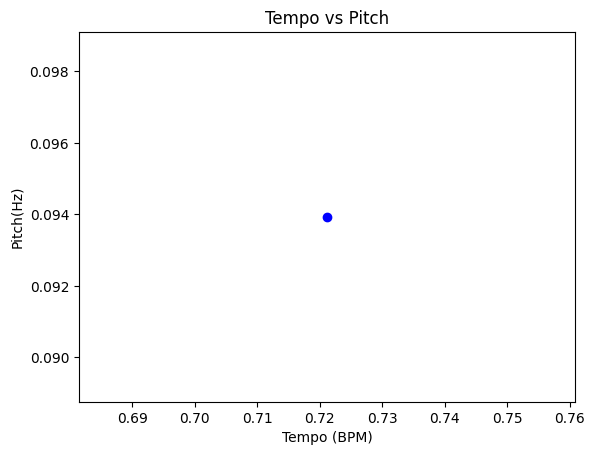

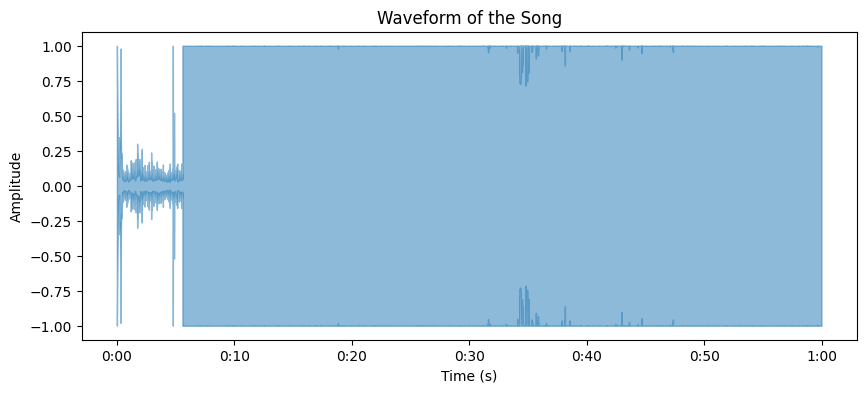

In [8]:
recognize_speech()